# Bayesian Linear Regression

In this notebook, we see how Bayesian linear regression algorithm (including the evidence approximation) described in chapter 3 of PRML can be implemented. 

In [1]:
import numpy as np
from scipy.linalg import eigh
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
np.random.seed(42)

# 1 Setting

* Let $N \in \mathbb{N}$ be the number of data points.
* Let $d \in \mathbb{N}$ be the dimension of the input.
* Denote input data as $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$, and output data as $t_0, t_1, \dots, t_{N-1} \in \mathbb{R}$. 
Also, let $\boldsymbol{t} = {}^t (t_0, t_1 \dots, t_{N-1}) \in \mathbb{R}^N$.

# 2. Theory

## 2.1 Model and design matrix

### 2.1.1 Model

We assume the following model: 
$$
\begin{align}
    p(t|x,w,\beta) = \mathcal{N}(t|w^{T}\phi(x),\beta^{-1})
    = \sqrt{\frac{\beta}{2\pi}} \exp\left\{-\frac{\beta}{2} \left[ t - w^{T}\phi(x) \right]^2  \right\},
\end{align}
$$
where
* $\beta > 0$ is the precision of the Gaussian distribution, which is a hyper parameter,  
* $\phi : \mathbb{R}^d \rightarrow \mathbb{R}^M $ are basis functions which we specify later, and $\phi(x) := (\phi_0(x), \phi_1(x), \dots, \phi_{M-1}(x))^T$ with $M$ being the number of basis functions, 
* $w \in \mathbb{R}^M$ is a parameter (weight).

The model means that the output $t$ is the sum of a function of $x$ and a noise $\varepsilon \sim \mathcal{N}(0,\beta^{-1})$.

We also assume that, given the inputs $x_0, x_1, \dots, x_{N-1}$, the output $t_0, t_1 \dots, t_{N-1}$ are generated independently according the above model with $x$ being the corresponding input data.

For the later convenience, let tha matrix $\Phi$, which is called a design matrix, be
$$
\begin{align}
    \Phi = (\Phi_{i,j}), \ \ \Phi_{i,j} = \phi_j(x_i). 
\end{align}
$$
Note that the shape of $\Phi$ is $N \times M$.

### 2.1.2 Basis functions and design matrix

As basis functions, we use Gaussian basis functions in this notebook, where we set
$$
\begin{align}
    &{} \phi_0 (x) = 1 \\
    &{} \phi_j(x) = \exp\left[ -\frac{(x-\mu_j)^2}{2 s^2} \right] \ \ (j = 1, \dots, M-1), 
\end{align}
$$
where $\mu_j$ and $s$ stands for the center and the width of each Gaussian, respectively, which are assumed to be given.

## 2.2 Bayesian linear regression
   
### 2.2.1 Posterior distribution of the parameter $w$

From the model described in the previous section, the likelihood is given by
$$
\begin{align}
    p(t_1, \dots, t_N | w, \beta) = \prod_{n=1}^{N} \mathcal{N}(t_n|w^T\phi(x_n), \beta^{-1}). 
\end{align}
$$

As a prior for $w$, we take
$$
\begin{align}
    p(w|\alpha) = \mathcal{N}(w|m_0,S_0), 
\end{align}
$$
where $m_0 \in \mathbb{R}^M$, and $S_0$ is a $(M,M)$ real positive-definite symmetric matrix.

With this prior, the posterior distribution becomes (see (3.49)-(3.51) of the book):
$$
\begin{align}
    &{} p(w|t_1, \dots , t_n) = \mathcal{N}(w|m_N,S_N) \\
    &{} m_N := S_N (S_{0}^{-1}m_0 + \beta \Phi^T t) \\
    &{} S_N := \left( S_{0}^{-1} + \beta \Phi^T \Phi \right)^{-1} \\
    &{} \Phi = (\Phi_{i,j}), \ \ \Phi_{i,j} = \phi_j(x_i)
\end{align}
$$
In particular, if we set $m_0 = 0$, $S_0 = \frac{1}{\alpha} I$, where $\alpha > 0$, we have:
$$
\begin{align}
    &{} m_N := \beta S_N \Phi^T t \\
    &{} S_N := \left( \alpha I  + \beta \Phi^T \Phi \right)^{-1}
\end{align}
$$
From now on, we assume this form of $m_0, S_0$. 

### 2.2.2 Predictive distribution

From the posterior distribution of $w$, we can compute the predictive distribution of $t$ (see (3.57)-(3.59) of the book)
$$
\begin{align}
    p(t| x, \boldsymbol{t}, \alpha, \beta)
    & :=  \int dw \ p(t|x, w,\beta) p(w | \boldsymbol{t}, \alpha, \beta) \\
    & =  \mathcal{N}(t| m_{N}^{T} \phi(x), \sigma_{N}^{2}(x)) ,  
\end{align}
$$
where
$$
\begin{align}
    \sigma_{N}^{2}(x) = \frac{1}{\beta} + \phi(x)^T S_N \phi(x)
\end{align}
$$

## 2.3 Empirical Bayes approximation

In empirical Bayes method (or evidence approximation), we determine hyper parameters from our data, 
by selecting hyper parameters that maximize a quantity called evidence (or marginal likelihood).

### 2.3.1 Evidence

The evidence $p(\boldsymbol{t}|\alpha,\beta)$ is given by (see (3.86) of the book):
$$
\begin{align}
    \log p(\boldsymbol{t}|\alpha,\beta) 
    &= \frac{M}{2} \log \alpha + \frac{N}{2} \log \beta - E(m_N) - \frac{1}{2} \log\left|\alpha I_M + \beta \Phi^T \Phi\right| - \frac{N}{2} \log ( 2\pi) \\
    E(m_N) &:=
    \frac{\beta}{2} \| \boldsymbol{t} -  \Phi m_N \|^2 + \frac{\alpha}{2} m_{N}^{T} m_{N}
\end{align}
$$

Note that $m_N$ depends on $\alpha, \beta$.


### 2.3.2 Optimization with respect to $\alpha, \beta$

By differentiating the log of evidence, we obtain the stationary conditions (see (3.91), (3.92), (3.95) of the book) : 
$$
\begin{align}
    \lambda_i &: \ \mbox{Eigenvalues of } \beta\Phi^T \Phi \\
    \gamma &:= \sum_{i=1}^{M} \frac{\lambda_i}{ \lambda_i + \alpha} \\
    \alpha &= \frac{\gamma}{m_{N}^{T} m_{N} } \\
    \beta &= \frac{N-\gamma}{\| \boldsymbol{t} - \Phi m_N \|^2}
\end{align}
$$

Note that $\gamma$, $m_N$ depends on $\alpha,\beta$.
As was mentioned by the textbook, later we solve these equations iteratively.

# 3 From math to code

## 3.1 Overview 

We define 
* A function that generates a design matrix.
* A `BayesianRidgeRegression` class representing the bayesian linear regression estimator, with `fit` and `predict` method.

## 3.2 Generating design matrix

Here we consider how to write a function that generates the design matrix $\Phi$ from input data and $\mu_j$ s and $s$.

In the following codes, we vectorize the calculation of $\phi_j(x)$, which is a little bit tricky, so let's take a closer look.

The $(n,m+1)$ component of $\Phi$ can be expressed as ($X$ stands for 'X', and $\mathcal{M}$ stands for params['mus'])

\begin{equation}
    \Phi_{n,m+1} = \exp\left[ -\frac{1}{2 s^2} \sum_{i=1}^{d} \left(X_{n,i} - \mathcal{M}_{m,i} \right)^2 \right]
\end{equation}

Because we can apply 'np.exp' elementwise, it suffices to consider the quantity

$$
\begin{align}
    A_{n,m} &:= \sum_{i=1}^{d} \left(X_{n,i} - \mathcal{M}_{m,i} \right)^2 \\
    &= \sum_{i=1}^{d} X_{n,i}^{2} + \sum_{i=1}^{d} \mathcal{M}_{m,i}^{2} - 2 \sum_{i=1}^{d} X_{n,i} \mathcal{M}_{m,i}
\end{align}
$$

Then, we can calculate the (N,M-1) array A with numpy broadcasting (see the following code):

* 1: First, `-2*(X@(mus.T))` creates a (N,M-1) array, which corresponds to the third term of the above equation.
* 2: Then, `np.reshape(np.sum(X**2, axis=1), (len(X), -1))` create a (N,1) array, which corresponds to the first term of the above equation. The array will be added to the (N,M-1)array created earlier, where numpy broadcasting take care of matching the shape of the array (Note that the reshape command is required here).
* 3: Finally, `np.sum(mus**2, axis=1)` create a (M-1,) array, which corresponds to the second term in the above equation. When the array is added to the (N,M-1) array, broadcasting takes place too.

In [2]:
def gen_desmat_gaussian(X, params):
    """
    This function generates a design matrix with basis function being Gaussian.
    
    Parameters
    ----------
    X :  2-D numpy array
        (N,d) numpy array, with X[n, i] = i-th element of x_n
    
    params : dictionary
        Dictionary of parameters of Gaussian basis function with
        params['mus'] : (M-1,d) numpy array. params['mus'][j] being the center of the jth Gaussian
        params['s'] : double. positive real number, which stands for the width of Gaussians
    
    Returns
    ----------
    Phi: 2-D numpy array
        (N,M) array, with Phi[n, m] = $\phi_m(x_n)$
    
    """
    
    s = params['s']
    mus = params['mus']
    Phi = np.zeros((len(X),len(mus)+1))
    Phi[:,0] = np.ones(len(X)) # the 0-the basis is a constant
    A = ( -2*(X@(mus.T)) + np.reshape(np.sum(X**2, axis=1), (len(X), -1)) ) + np.sum(mus**2, axis=1)
    Phi[:,1:] = np.exp(-A/(2*s*s))
    return Phi

## 3.3 Bayesian regression

Next, we define our estimator. We require the estimator to be capable of
* calculating the posterior mean and variance given training data and hyper parameters $\alpha$ and $\beta$
* calculating predictive variance given input $\Phi$, and
* performing evidence approximation.


### 3.3.1 Posterior parameters

For the first aim, we define `calc_posterior_params` method, which calculates posterior mean $m_N$ (`self.m`) and posterior covariance matrix $S_N$ (`self.S`) according to
$$
\begin{align}
    &{} m_N := \beta S_N \Phi^T t \\
    &{} S_N := \left( \alpha I  + \beta \Phi^T \Phi \right)^{-1}
\end{align}
$$

### 3.3.2 Prediction
For the second aim, we define `predict` method, which returns predictive mean  $m_{N}^{T} \phi(x)$ and predictive standard deviation $\sigma_{N}(x)$ according to
$$
\begin{align}
    \sigma_{N}^{2}(x) = \frac{1}{\beta} + \phi(x)^T S_N \phi(x)
\end{align}
$$

Assuming the input $\Phi$ is a $(N_{test}, M)$ array, we want the `predict` method to return two $(N_{test}, )$ arrays `pred_mean` (corresponding to $m_{N}^{T} \phi(x)$) and `pred_std` (corresponding to $\sigma_{N}(x)$)

To vectorize the calculation, note that these quantities can be implemented by matrix multiplication.

### 3.3.3 Empirical Bayes

We first define `calc_evidence`, a method for calculating the evidence
$$
\begin{align}
    \log p(\boldsymbol{t}|\alpha,\beta) 
    &= \frac{M}{2} \log \alpha + \frac{N}{2} \log \beta - E(m_N) - \frac{1}{2} \log\left|\alpha I_M + \beta \Phi^T \Phi\right| - \frac{N}{2} \log ( 2\pi) \\
    E(m_N) &:=
    \frac{\beta}{2} \| \boldsymbol{t} -  \Phi m_N \|^2 + \frac{\alpha}{2} m_{N}^{T} m_{N}
\end{align}
$$
Note that we do not need the function for the optimization with respect to $\alpha$ and $\beta$.

Then, we define `empirical_bayes` which performs the optimization with respect to $\alpha$ and $\beta$ by solving the following self-consistent equation iteratively.
$$
\begin{align}
    \lambda_i &: \ \mbox{Eigenvalues of } \beta\Phi^T \Phi \\
    \gamma &:= \sum_{i=1}^{M} \frac{\lambda_i}{ \lambda_i + \alpha} \\
    \alpha &= \frac{\gamma}{m_{N}^{T} m_{N} } \\
    \beta &= \frac{N-\gamma}{\| \boldsymbol{t} - \Phi m_N \|^2}
\end{align}
$$


### 3.3.4 Code

In [3]:
class BayesianRidgeRegression:
    
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha
        self.beta = beta
        self.m = None # posterior mean
        self.S = None # posterior covariancematrix
        
    
    def calc_posterior_params(self, Phi, t):
        """
        This method calculates posterior mean and covariance matrix from the training data Phi and t.
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy arra
            (N,) array, representing target values
        """
        self.S = np.linalg.inv(self.alpha*np.identity(len(Phi[0])) + self.beta*(Phi.T)@Phi )
        self.m = self.beta * ( self.S @ (Phi.T) @ t)


    def predict(self, Phi, return_std=False):
        """
        This method makes prediction on the input Phi, and returns predictive mean (and standard deviation)
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N_test, M) numpy array. M must be equal to "M" (the length in the second dimension) of the training data.
        return_std : boolean, default False
            If True, the method also returns predictive standard deviation
            
        Returns 
        ----------
        pred_mean : 1-D numpy array
            (N_test,) numpy array representing predictive mean
        pred_std : 1-D numpy array
            (N_test,) numpy array representing predictive mean
        """
        pred_mean = Phi @ self.m
        if not(return_std):
            return pred_mean
        else:
            pred_std = np.sqrt(1.0/self.beta + np.diag(Phi @ self.S @ (Phi.T) ) )
            return pred_mean, pred_std
        
        
    def calc_evidence(self, Phi, t):
        """
        This method calculates the evidence with respect to the data Phi and t
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy arra
            (N,) array, representing target values
            
        Returns
        ----------
        evidence : float
        
        """
        N, M = np.shape(Phi)
        evidence = 0.5*M*np.log(self.alpha) + 0.5*N*np.log(self.beta) \
            - 0.5*self.beta*np.linalg.norm( t - Phi @ self.m )**2 - 0.5*self.alpha*(self.m@self.m) \
            - 0.5*np.log( np.linalg.det( self.alpha*np.identity(M) + self.beta*(Phi.T)@Phi ) ) \
            - 0.5*N*np.log(2*np.pi)
        return evidence
                
    
    def empirical_bayes(self, Phi, t, tol, maxiter, show_message=True):
        """
        This method performs empirical bayes (or evidence approximation), 
        where hyper parameters alpha and beta are chosen in such a way that they maximize the evidence. 
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy arra
            (N,) array, representing target values
        tol : float
            The tolerance. 
            If the changes of alpha and beta are smaller than the value, the iteration is judged as converged.
        maxiter : int
            The maximum number of iteration
        show_message : boolean, default True
            If True, the message indicating whether the optimization terminated successfully is shown.
        """
        tmp_lambdas = eigh((Phi.T)@Phi)[0]
        cnt = 0
        while cnt < maxiter:
            lambdas = self.beta * tmp_lambdas
            self.calc_posterior_params(Phi, t)
            
            alpha_old = self.alpha
            beta_old = self.beta
            
            gamma = np.sum( lambdas/ (self.alpha + lambdas) )
            self.alpha = gamma/np.dot(self.m, self.m)
            self.beta = (len(t) - gamma) / ( np.linalg.norm(t -  Phi @ self.m )**2    )
            if (abs(self.alpha - alpha_old) < tol) and ( abs(self.beta - beta_old) < tol ):
                break
            cnt += 1
        if show_message:
            if cnt <= maxiter:
                print(f"Optimization terminated succesfully. The number of iteration : {cnt}")
            else:
                print("Maximum number of iteration exceeded.")
                
    def fit(self, Phi, t, tol=1e-4, maxiter=100, show_message=True, optimize_hyperparams=False):
        """
        This method performs fitting. 
        The user can choose whether or not to perform empirical Bayes.
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy arra
            (N,) array, representing target values
        tol : float
            The tolerance. 
            If the changes of alpha and beta are smaller than the value, the iteration is judged as converged.
        maxiter : int
            The maximum number of iteration
        show_message : boolean, default True
            If True, the message indicating whether the optimization terminated successfully is shown.
        optimize_hyperparams : boolean, default False
            If True, the hyper parameters alpha and beta are optimized by empirical Bayes.
        """
        if optimize_hyperparams:
            self.empirical_bayes(Phi, t, tol, maxiter, show_message)
        self.calc_posterior_params(Phi, t)            

# 4 Experiment 

## 4.1 Data

As an example, we use $d=1, N = 50$ data, where $x_i \in \mathbb{R}$ are drawn from uniform distribution over $[-3,3]$, and
\begin{eqnarray}
    &{}& t = f(x) + \varepsilon \\
    &{}& f(x) = \sin(2x)  + 0.2\sin x + 0.1x \\
    &{}& \varepsilon \sim \mathcal{N}(0, 0.09)
\end{eqnarray}
The dataset is shown below:

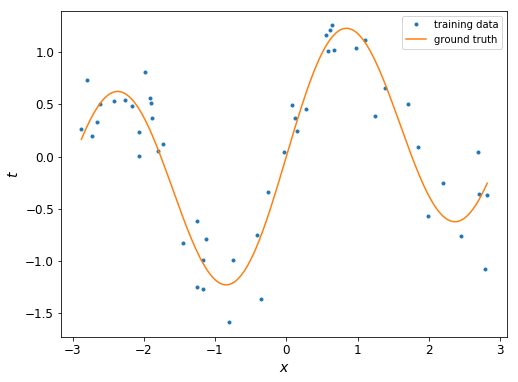

In [4]:
def truef(x):
    return np.sin(2*x)  + 0.2*np.sin(x) + 0.1*x

N = 50
X = np.random.uniform(-3, 3, N)
ep = 0.3*np.random.randn(N)
t = truef(X) + ep

Xcont = np.linspace(np.min(X),np.max(X),200) # for plotting

plt.figure(figsize=(8,6))
plt.plot(X, t,'.', label='training data')
plt.plot(Xcont, truef(Xcont), label='ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.legend()
plt.show()

X = np.reshape(X,(len(X),1))
Xtest = np.reshape(Xcont,(len(Xcont),1))

## 4.2 Bayesian linear regression with fixed hyper parameters

First, we see the results for bayesian linear regression with fixed hyper parameters. 
We also see that how the results change with different hyper parameters.

In [5]:
def plot_result(pred_mean, pred_std):
    plt.figure(figsize=(8,6))
    plt.plot(X, t,'.',label='training data')
    plt.plot(Xcont, pred_mean, label='predictive mean')
    plt.plot(Xcont, truef(Xcont), ':', label='ground truth')
    plt.fill_between(Xcont, pred_mean + pred_std, pred_mean - pred_std, alpha=0.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.legend()
    plt.show()    

def plot_prediction_fixed_hparams(s, mus, alpha, beta):
    # generating design matrix
    Phi = gen_desmat_gaussian(X,params={'s':s, 'mus':mus})
    Phi_test = gen_desmat_gaussian(Xtest,params={'s':s, 'mus':mus})
    
    est = BayesianRidgeRegression(alpha=alpha, beta=beta)
    est.fit(Phi, t, optimize_hyperparams=False)
    pred_mean, pred_std = est.predict(Phi_test, return_std=True)
    plot_result(pred_mean, pred_std)


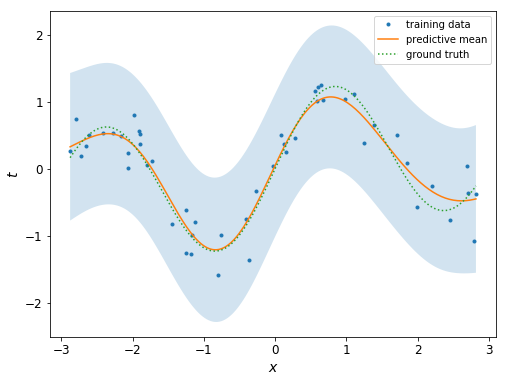

In [6]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
plot_prediction_fixed_hparams(s, mus, alpha=1.0, beta=1.0)

It seems that we are lucky, because, even though hyperparameters are chosen by hand without much consideration, the result looks not bad. However, if we are not lucky enough, we get weird results:

For example, if we make $\alpha$ too large, the regularization becomes too large.

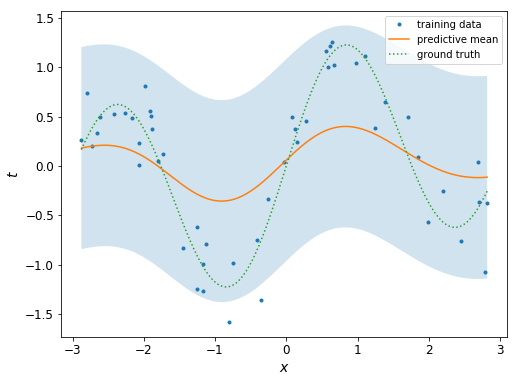

In [7]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
plot_prediction_fixed_hparams(s, mus, alpha=30.0, beta=1.0)

If we make $s$ too small, then the resulting predictive mean gets wiggling.

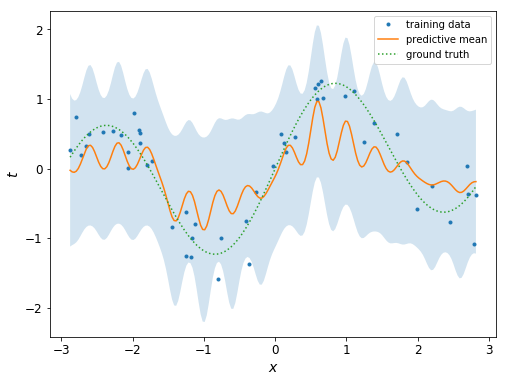

In [8]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.1
plot_prediction_fixed_hparams(s, mus, alpha=1.0, beta=1.0)

So far, we have chosen the value of hyper parameters by hand, but we are much better off if we can determine appropriate values of hyper parameters from data. 
That's what we will do in the next section by empirical bayes method.

## 4.3 Empirical Bayes


### 4.3.1 Maximization with respect to $\alpha$ and $\beta$

Optimization terminated succesfully. The number of iteration : 3
alpha=4.448284052876882 
beta=12.860678264859217


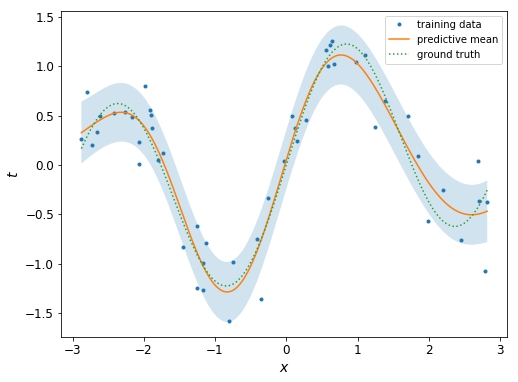

In [9]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
s = 0.5
params = {'s':s, 'mus':mus}
Phi = gen_desmat_gaussian(X, params = {'s':s, 'mus':mus})
Phi_test = gen_desmat_gaussian(Xtest,params={'s':s, 'mus':mus})

est = BayesianRidgeRegression(alpha=1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

print(f"alpha={est.alpha} \nbeta={est.beta}")
plot_result(pred_mean, pred_std)

It can be seen that credible intervals become smaller than those seen in the previous section.

### 4.3.2 Maximization with respect to $s$

Finally, we determine the value of $s$ from our data (assuming $\mu_j$s are fixed).

Because this procedure cannot be carried out analytically, we perform grid search, and plot the value of evidence for each $s$ (Note that the maximization with respect to $\alpha, \beta$ is performed for each $s$.). 

s=0.60625


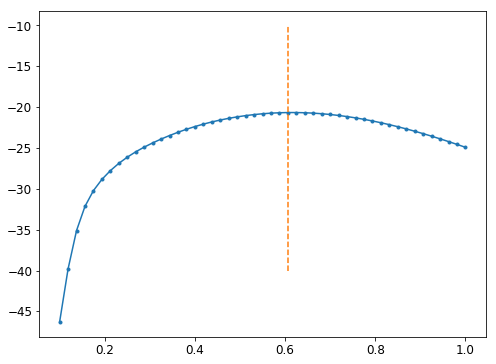

In [10]:
mus = np.reshape(np.linspace(-3, 3, 16), (16, 1))


ss = np.linspace(0.1, 1.0, 49)
arr_evidence = np.zeros(len(ss))

for (cnt,s) in enumerate(ss):
    Phi = gen_desmat_gaussian(X, {'s':s, 'mus':mus})
    est = BayesianRidgeRegression(alpha=1.0, beta=1.0)
    est.fit(Phi, t, tol=1e-4, maxiter=1e3, optimize_hyperparams=True, show_message=False)
    arr_evidence[cnt] = est.calc_evidence(Phi, t)

s = ss[np.argmax(arr_evidence)]
print(f"s={s}")
plt.figure(figsize=(8,6))
plt.plot(ss,arr_evidence,'.-')
plt.plot([s,s],[-40,-10],'--')
plt.show()

With this optimal values of $s, \alpha, \beta$, we obtain the following plot:

Optimization terminated succesfully. The number of iteration : 3
s=0.60625
alpha=3.634825844752948 
beta=13.024570712161763


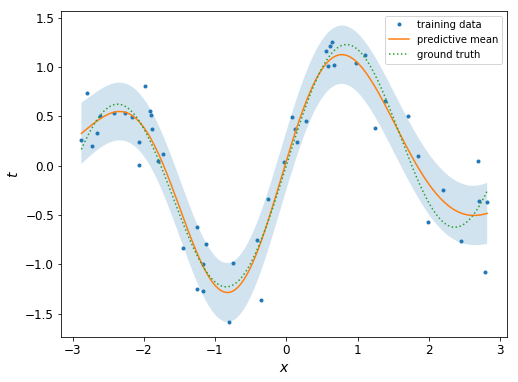

In [11]:
mus = np.reshape(np.linspace(-3,3,16),(16,1))
params = {'s':s, 'mus':mus}
Phi = gen_desmat_gaussian(X, params = {'s':s, 'mus':mus})
Phi_test = gen_desmat_gaussian(Xtest,params={'s':s, 'mus':mus})

est = BayesianRidgeRegression(alpha=1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

print(f"s={s}\nalpha={est.alpha} \nbeta={est.beta}")
plot_result(pred_mean, pred_std)

# Appendix : scikit-learn

In this appendix, we see how we can use the scikit-learn library to perform the above analysis.

Strictly speaking, the implementention is slightly different from ours in that they also consider priors (which are Gamma distributions) on $\alpha$ and $\beta$. 

However, if we take the priors to be uninformative, the result closely resembles to the result shown above.

For detail, see official documentations :
* http://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html

s=0.60625
alpha=3.634829359779728 
beta=13.024559477195034


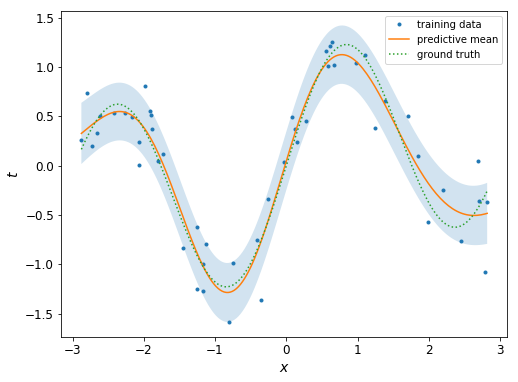

In [12]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(fit_intercept=False)

# prepare the design matrix
mus = np.reshape(np.linspace(-3, 3, 16), (16, 1))
params = {'s':s, 'mus':mus}

# perform the fitting (optimization with respect to alpha and beta is also performed)
Phi = gen_desmat_gaussian(X, params = {'s':s, 'mus':mus})
reg.fit(Phi, t)

Phi_test = gen_desmat_gaussian(Xtest, params)
pred_mean,pred_std = reg.predict(Phi_test, return_std=True)

print(f's={s}\nalpha={reg.lambda_} \nbeta={reg.alpha_}')
plot_result(pred_mean, pred_std)
plt.show()